# Mesozooplankton (COPEPOD database) vs Control

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
#import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

# input file

In [12]:
## print('What is the new file? (new_file)')
new_file = input('')
print('What year? (year)')
year = input('')

 GNG595


What year? (year)


 20yrclim


In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009. 
newNCDFfiles = sorted(glob.glob('/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/GNG595_2ndcycle_1990-2009_clim/*', recursive=True),
                      key=numericalSort)
new = xr.open_mfdataset(newNCDFfiles,combine='by_coords')

## Regridded mesozooplankton

In [5]:
files = '/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_2ndcycle_1990-2009_clim/regrid'
zoo3_inds = sorted(glob.glob(f'{files}/regrid_SPECTRA_zoo3C.*.nc', recursive=True))
zoo3_ds = xr.open_mfdataset(zoo3_inds,combine='by_coords')
zoo4_inds = sorted(glob.glob(f'{files}/regrid_SPECTRA_zoo4C.*.nc', recursive=True))
zoo4_ds = xr.open_mfdataset(zoo4_inds,combine='by_coords')
zoo5_inds = sorted(glob.glob(f'{files}/regrid_SPECTRA_zoo5C.*.nc', recursive=True))
zoo5_ds = xr.open_mfdataset(zoo5_inds,combine='by_coords')
zoo6_inds = sorted(glob.glob(f'{files}/regrid_SPECTRA_zoo6C.*.nc', recursive=True))
zoo6_ds = xr.open_mfdataset(zoo6_inds,combine='by_coords')

In [6]:
mesozooC_regrid = zoo3_ds.zoo3C+zoo4_ds.zoo4C+zoo5_ds.zoo5C+zoo6_ds.zoo6C #mmol/m^3
mesozooC_regrid = mesozooC_regrid.isel(z_t_150m=slice(None,10)).mean(dim='z_t_150m')* 12.011 #mg C/m^3

In [7]:
mesozooC_regrid.shape

(12, 180, 360)

## Zooplankton Observations

In [8]:
# COPEPOD dataset from Moriarty & O'Brien 2013
cope_path = '/glade/u/home/jluo/work/obs/COPEPOD/data/'
cope_files = sorted(glob.glob(cope_path + 'copepod-2012__cmass-m0[1-9]-qtr.nc') + glob.glob(cope_path + 'copepod-2012__cmass-m1[0-2]-qtr.nc'))
dzt = xr.open_mfdataset(cope_files, combine='by_coords')
dzt = dzt.compute()

# z-ratio
zratio_path = '/glade/work/jluo/obs/z-ratio/data/1deg_temp_variable/'
dz = xr.open_dataset(zratio_path + 'copepod-2012_zratio_m00.nc', decode_times=False)

	NC4_open: path /glade/u/home/jluo/work/obs/COPEPOD/data/copepod-2012__cmass-m01-qtr.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/u/home/jluo/work/obs/COPEPOD/data/copepod-2012__cmass-m01-qtr.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset time
			found dataset lat
			found dataset lon
			found dataset n
			found dataset carbon_biomass
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0x3d0000 ext_ncid 0x3d0000
		FILE - path: /glade/u/home/jluo/work/obs/COPEPOD/data/copepod-2012__cmass-m01-qtr.nc cmode: 0x1008 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 5 natts: 0
		 DIMENSION - dimid: 0 name: time len: 1 unlimited: 0
		 DIMENSION - dimid: 1 name: lat len: 720 unlimited: 0
		 DIMENSION - dimid: 2 name: lon len: 1440 unlimited: 0
		 VARIABLE - varid: 0 name: time ndims: 1 dimscale: 1 dimids: 0
		 VARIABLE - varid: 

In [9]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [10]:
# Preparing the Modeled mesozooplankton to only match areas that have observations
obs_meso = dz.carbon_biomass.isel(time=0).values
# this finds the summer in the Northern Hemisphere, and the summer in the Southern Hemisphere 
N_hem = np.nanmean(mesozooC_regrid[5:8,0:90,:],axis=(0))
S_hem = np.nanmean(mesozooC_regrid[[0,1,-1],90:180,:],axis=(0))
model_meso = np.concatenate((N_hem, S_hem), axis=0)
ind_data = np.isnan(obs_meso) # this finds the values that are NaN in the observations
model_meso[ind_data] = np.nan # this makes the values that are NaN on the obs to NaN in SPECTRA

		NC4_inq_var_all: ncid 0x3d0000 varid 2
		NC4_inq_var_all: ncid 0x3d0000 varid 2
		NC4_inq_dim: ncid 0x3d0000 dimid 2
		NC4_inq_dim: ncid 0x3d0000 dimid 0
		NC4_inq_dim: ncid 0x3d0000 dimid 1
		NC4_inq_dim: ncid 0x3d0000 dimid 2
		NC4_inq_dim: ncid 0x3d0000 dimid 0
		NC4_inq_dim: ncid 0x3d0000 dimid 1
		NC4_inq_var_all: ncid 0x3d0000 varid 2
		NC4_inq_var_all: ncid 0x3d0000 varid 2
		NC4_inq_dim: ncid 0x3d0000 dimid 2
		NC4_inq_dim: ncid 0x3d0000 dimid 0
		NC4_inq_dim: ncid 0x3d0000 dimid 1
		NC4_inq_var_all: ncid 0x3d0000 varid 2
		NC4_inq_var_all: ncid 0x3d0000 varid 2
		NC4_inq_dim: ncid 0x3d0000 dimid 2
		NC4_inq_dim: ncid 0x3d0000 dimid 0
		NC4_inq_dim: ncid 0x3d0000 dimid 1
		NC4_inq_var_all: ncid 0x3d0000 varid 2
			NC4_get_vars: var->hdr.name carbon_biomass mem_nc_type 6
		NC4_inq_var_all: ncid 0x3d0000 varid 2
		NC4_inq_var_all: ncid 0x3d0000 varid 2
		NC4_inq_dim: ncid 0x3d0000 dimid 2
		NC4_inq_dim: ncid 0x3d0000 dimid 0
		NC4_inq_dim: ncid 0x3d0000 dimid 1
		NC4_inq_att: n

		NC4_inq_var_all: ncid 0x3d0000 varid 2
		NC4_inq_var_all: ncid 0x3d0000 varid 2
		NC4_inq_dim: ncid 0x3d0000 dimid 2
		NC4_inq_dim: ncid 0x3d0000 dimid 0
		NC4_inq_dim: ncid 0x3d0000 dimid 1
		NC4_inq_dim: ncid 0x3d0000 dimid 2
		NC4_inq_dim: ncid 0x3d0000 dimid 0
		NC4_inq_dim: ncid 0x3d0000 dimid 1
		NC4_inq_var_all: ncid 0x3d0000 varid 2
		NC4_inq_var_all: ncid 0x3d0000 varid 2
		NC4_inq_dim: ncid 0x3d0000 dimid 2
		NC4_inq_dim: ncid 0x3d0000 dimid 0
		NC4_inq_dim: ncid 0x3d0000 dimid 1
		NC4_inq_var_all: ncid 0x3d0000 varid 2
		NC4_inq_var_all: ncid 0x3d0000 varid 2
		NC4_inq_dim: ncid 0x3d0000 dimid 2
		NC4_inq_dim: ncid 0x3d0000 dimid 0
		NC4_inq_dim: ncid 0x3d0000 dimid 1
		NC4_inq_var_all: ncid 0x3d0000 varid 2
			NC4_get_vars: var->hdr.name carbon_biomass mem_nc_type 6
		NC4_inq_var_all: ncid 0x3d0000 varid 2
		NC4_inq_var_all: ncid 0x3d0000 varid 2
		NC4_inq_dim: ncid 0x3d0000 dimid 2
		NC4_inq_dim: ncid 0x3d0000 dimid 0
		NC4_inq_dim: ncid 0x3d0000 dimid 1
		NC4_inq_att: n

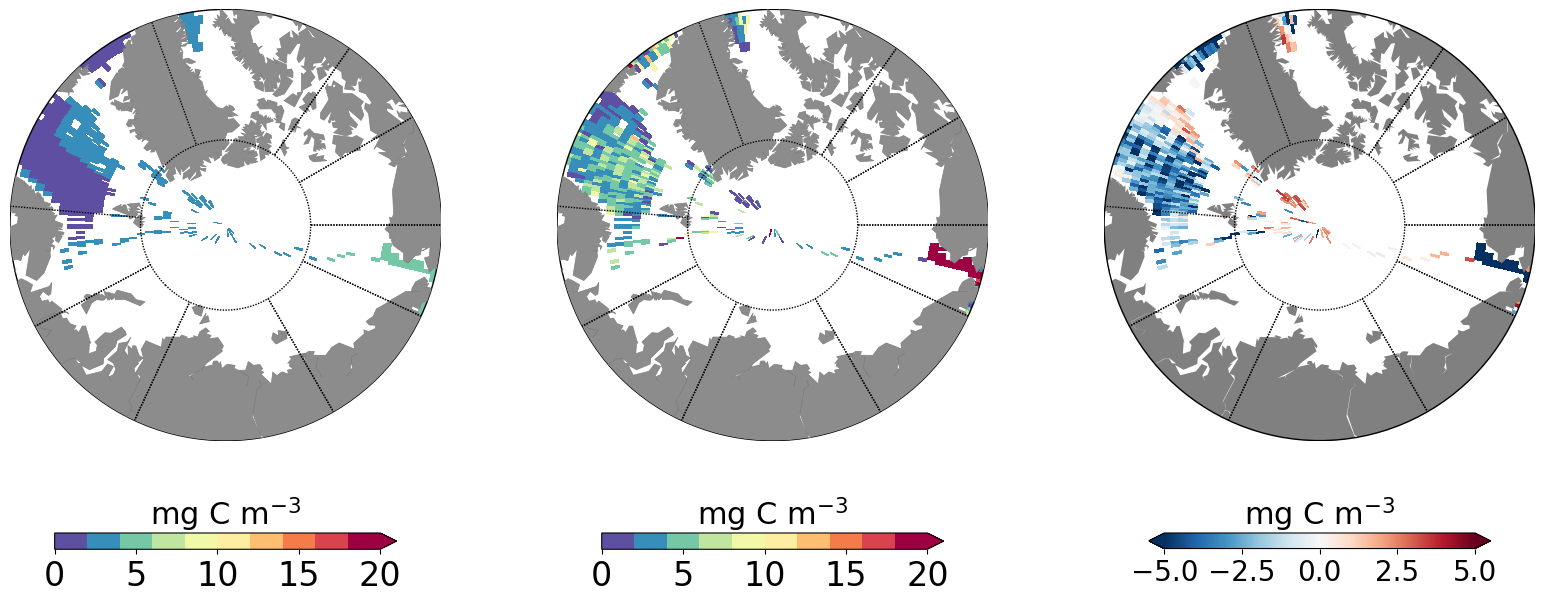

In [19]:
fig = plt.figure(figsize=(20, 8))
lat = dz.lat.values
ax = fig.add_subplot(1, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
mod, lon = add_cyclic_point(model_meso, coord=dz.lon.values, axis=1)
x, y = m(*np.meshgrid(lon,lat))
cf = m.pcolormesh(x,y,mod,shading='flat',cmap=plt.cm.get_cmap('Spectral_r', 10),vmin = 0, vmax=20) 
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
cb = plt.colorbar(cf, ticks=[0,5,10,15,20],extend = 'max',shrink=0.75, orientation='horizontal')
cb.ax.set_xticklabels(['0','5','10','15','20'])
cb.ax.set_title('mg C m$^{-3}$', fontsize = 22)
#ax.set_title('SPECTRA', fontsize =20)
cb.ax.tick_params(labelsize=24)

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[0, 0, 0, 0])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[0, 0, 0, 0])
m.drawmeridians((235,260), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[0, 0, 0, 0])
m.drawmeridians((260,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[0, 0, 0, 0])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[0, 0, 0, 0])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[0, 0, 0, 0])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[0, 0, 0, 0])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[0, 0, 0, 0])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])

ax = fig.add_subplot(1, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
obs, lon = add_cyclic_point(dz.carbon_biomass.isel(time=0).values, coord=dz.lon.values, axis=1)
x, y = m(*np.meshgrid(lon,lat))
cf = m.pcolormesh(x,y,obs,shading='flat',cmap=plt.cm.get_cmap('Spectral_r', 10),vmin = 0, vmax=20) 
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
cb = plt.colorbar(cf, ticks=[0,5,10,15,20],extend = 'max',shrink=0.75, orientation='horizontal')
cb.ax.set_xticklabels(['0','5','10','15','20'])
cb.ax.set_title('mg C m$^{-3}$', fontsize = 22)
#ax.set_title('COPEPOD', fontsize =20)
cb.ax.tick_params(labelsize=24)

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[0, 0, 0, 0])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[0, 0, 0, 0])
m.drawmeridians((235,260), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[0, 0, 0, 0])
m.drawmeridians((260,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[0, 0, 0, 0])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[0, 0, 0, 0])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[0, 0, 0, 0])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[0, 0, 0, 0])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[0, 0, 0, 0])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])

ax = fig.add_subplot(1, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x,y,mod-obs,cmap='RdBu_r', vmin = -5, vmax = 5)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('mg C m$^{-3}$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
#ax.set_title('SPECTRA - COPEPOD', fontsize =20)

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[0, 0, 0, 0])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[0, 0, 0, 0])
m.drawmeridians((235,260), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[0, 0, 0, 0])
m.drawmeridians((260,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[0, 0, 0, 0])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[0, 0, 0, 0])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[0, 0, 0, 0])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[0, 0, 0, 0])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[0, 0, 0, 0])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])
fig.savefig('/glade/u/home/gabyn/work/case_notes/analysis_figures/mesozooplankton_AO_annual_comparison'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

## There is no seasonality in the COPEPOD batabase

In [13]:
# Model Chlorophyll for every region 
model_ao = np.nanmean(model_meso[170:180,:], axis=(0,1))
model_cs = np.nanmean(model_meso[149:170,0:25], axis=(0,1))
model_bs = np.nanmean(model_meso[149:170,25:55], axis=(0,1))
model_ca = np.nanmean(model_meso[149:170,55:110], axis=(0,1))
model_bb = np.nanmean(model_meso[149:170,110:135], axis=(0,1))
model_ess = np.nanmean(model_meso[149:170,325:360], axis=(0,1))
model_ls = np.nanmean(model_meso[149:170,270:325], axis=(0,1))
model_ns = np.nanmean(model_meso[149:170,155:205], axis=(0,1))
model_bts =np.nanmean(model_meso[149:170,205:233], axis=(0,1))
model_ks = np.nanmean(model_meso[149:170,233:270], axis=(0,1))

# Observed Chlorophyll for every region. 
obs_ao = np.nanmean(dz.carbon_biomass.isel(time=0).values[170:180,:], axis=(0,1))
obs_cs = np.nanmean(dz.carbon_biomass.isel(time=0).values[149:170,0:25], axis=(0,1))
obs_bs = np.nanmean(dz.carbon_biomass.isel(time=0).values[149:170,25:55], axis=(0,1))
obs_ca = np.nanmean(dz.carbon_biomass.isel(time=0).values[149:170,55:110], axis=(0,1))
obs_bb = np.nanmean(dz.carbon_biomass.isel(time=0).values[149:170,110:135], axis=(0,1))
obs_ess = np.nanmean(dz.carbon_biomass.isel(time=0).values[149:170,325:360], axis=(0,1))
obs_ls = np.nanmean(dz.carbon_biomass.isel(time=0).values[149:170,270:325], axis=(0,1))
obs_ns = np.nanmean(dz.carbon_biomass.isel(time=0).values[149:170,155:205], axis=(0,1))
obs_bts =np.nanmean(dz.carbon_biomass.isel(time=0).values[149:170,205:233], axis=(0,1))
obs_ks = np.nanmean(dz.carbon_biomass.isel(time=0).values[149:170,233:270], axis=(0,1))

## Now create 1:1 line with the average of each region with sd 

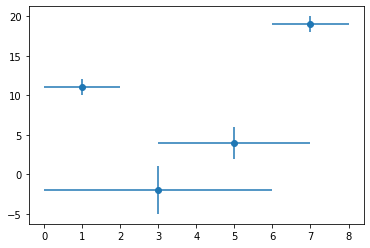

In [110]:
## Example of what I would like to have
import matplotlib.pyplot as plt
a = [1,3,5,7]
b = [11,-2,4,19]
plt.scatter(a,b)

c = [1,3,2,1]
plt.errorbar(a,b,yerr=c,xerr=c, linestyle="None")

plt.show()

### Finding the error: 
percent error = (model - obs)/obs * 100

In [14]:
# This is the error on the observations
err_ao = np.abs((np.nanmean(model_ao) -np.nanmean(obs_ao))/np.nanmean(obs_ao))
err_cs = np.abs((np.nanmean(model_cs) -np.nanmean(obs_cs))/np.nanmean(obs_cs))
err_bs = np.abs((np.nanmean(model_bs) -np.nanmean(obs_bs))/np.nanmean(obs_bs))
err_ca = np.abs((np.nanmean(model_ca) -np.nanmean(obs_ca))/np.nanmean(obs_ca))
err_bb = np.abs((np.nanmean(model_bb) -np.nanmean(obs_bb))/np.nanmean(obs_bb))
err_ess = np.abs((np.nanmean(model_ess) -np.nanmean(obs_ess))/np.nanmean(obs_ess))
err_ls = np.abs((np.nanmean(model_ls) -np.nanmean(obs_ls))/np.nanmean(obs_ls))
err_ns = np.abs((np.nanmean(model_ns) -np.nanmean(obs_ns))/np.nanmean(obs_ns))
err_bts = np.abs((np.nanmean(model_bts) -np.nanmean(obs_bts))/np.nanmean(obs_bts))
err_ks = np.abs((np.nanmean(model_ks) -np.nanmean(obs_ks))/np.nanmean(obs_ks))

# This is the error on the model
err_aom = np.abs((np.nanmean(obs_ao) -np.nanmean(model_ao))/np.nanmean(model_ao))
err_csm = np.abs((np.nanmean(obs_cs) -np.nanmean(model_cs))/np.nanmean(model_cs))
err_bsm = np.abs((np.nanmean(obs_bs) -np.nanmean(model_bs))/np.nanmean(model_bs))
err_cam = np.abs((np.nanmean(obs_ca) -np.nanmean(model_ca))/np.nanmean(model_ca))
err_bbm = np.abs((np.nanmean(obs_bb) -np.nanmean(model_bb))/np.nanmean(model_bb))
err_essm = np.abs((np.nanmean(obs_ess) -np.nanmean(model_ess))/np.nanmean(model_ess))
err_lsm = np.abs((np.nanmean(obs_ls) -np.nanmean(model_ls))/np.nanmean(model_ls))
err_nsm = np.abs((np.nanmean(obs_ns) -np.nanmean(model_ns))/np.nanmean(model_ns))
err_btsm = np.abs((np.nanmean(obs_bts) -np.nanmean(model_bts))/np.nanmean(model_bts))
err_ksm = np.abs((np.nanmean(obs_ks) -np.nanmean(model_ks))/np.nanmean(model_ks))

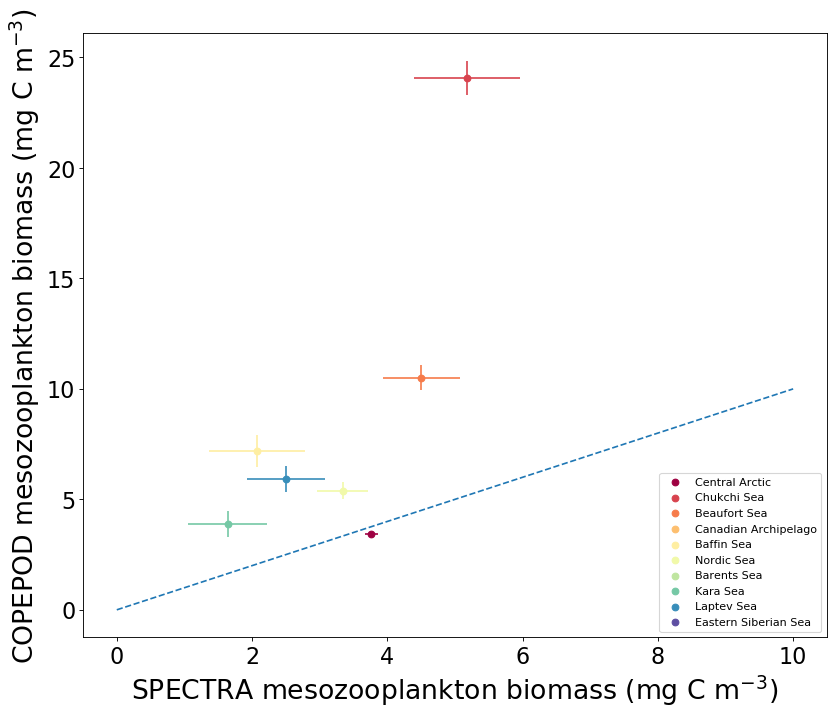

In [114]:
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

cmap=matplotlib.cm.get_cmap('Spectral', 10)

plt.scatter(np.nanmean(model_ao),np.nanmean(obs_ao),color=cmap(0),label='Central Arctic')
plt.errorbar(np.nanmean(model_ao),np.nanmean(obs_ao),yerr=err_ao,xerr=err_ao, color=cmap(0),linestyle="None")

plt.scatter(np.nanmean(model_cs),np.nanmean(obs_cs),color=cmap(1),label='Chukchi Sea')
plt.errorbar(np.nanmean(model_cs),np.nanmean(obs_cs),yerr=err_cs,xerr=err_cs, color=cmap(1),linestyle="None")

plt.scatter(np.nanmean(model_bs),np.nanmean(obs_bs), color=cmap(2),label='Beaufort Sea')
plt.errorbar(np.nanmean(model_bs),np.nanmean(obs_bs),yerr=err_bs,xerr=err_bs, color=cmap(2),linestyle="None")

plt.scatter(np.nanmean(model_ca),np.nanmean(obs_ca), color=cmap(3),label='Canadian Archipelago')
plt.errorbar(np.nanmean(model_ca),np.nanmean(obs_ca),yerr=err_ca,xerr=err_ca, color=cmap(3),linestyle="None")

plt.scatter(np.nanmean(model_bb),np.nanmean(obs_bb), color=cmap(4),label='Baffin Sea')
plt.errorbar(np.nanmean(model_bb),np.nanmean(obs_bb),yerr=err_bb,xerr=err_bb, color=cmap(4),linestyle="None")

plt.scatter(np.nanmean(model_ess),np.nanmean(obs_ess), color=cmap(5),label='Nordic Sea')
plt.errorbar(np.nanmean(model_ess),np.nanmean(obs_ess),yerr=err_ess,xerr=err_ess, color=cmap(5),linestyle="None")

plt.scatter(np.nanmean(model_ls),np.nanmean(obs_ls),color=cmap(6),label='Barents Sea')
plt.errorbar(np.nanmean(model_ls),np.nanmean(obs_ls),yerr=err_ls,xerr=err_ls, color=cmap(6),linestyle="None")

plt.scatter(np.nanmean(model_ns),np.nanmean(obs_ns), color=cmap(7),label='Kara Sea')
plt.errorbar(np.nanmean(model_ns),np.nanmean(obs_ns),yerr=err_ns,xerr=err_ns, color=cmap(7),linestyle="None")

plt.scatter(np.nanmean(model_bts),np.nanmean(obs_bts), color=cmap(8),label='Laptev Sea')
plt.errorbar(np.nanmean(model_bts),np.nanmean(obs_bts),yerr=err_bts,xerr=err_bts, color=cmap(8),linestyle="None")

plt.scatter(np.nanmean(model_ks),np.nanmean(obs_ks), color=cmap(9),label='Eastern Siberian Sea')
plt.errorbar(np.nanmean(model_ks),np.nanmean(obs_ks),yerr=err_ks,xerr=err_ks, color=cmap(9),linestyle="None")

plt.plot([0,1,2,3,4,10], [0,1,2,3,4,10], '--')
plt.legend(loc='lower right')
plt.xlabel('SPECTRA mesozooplankton biomass (mg C m$^{-3}$)', fontsize=24)
plt.ylabel('COPEPOD mesozooplankton biomass (mg C m$^{-3}$)', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)

plt.show()

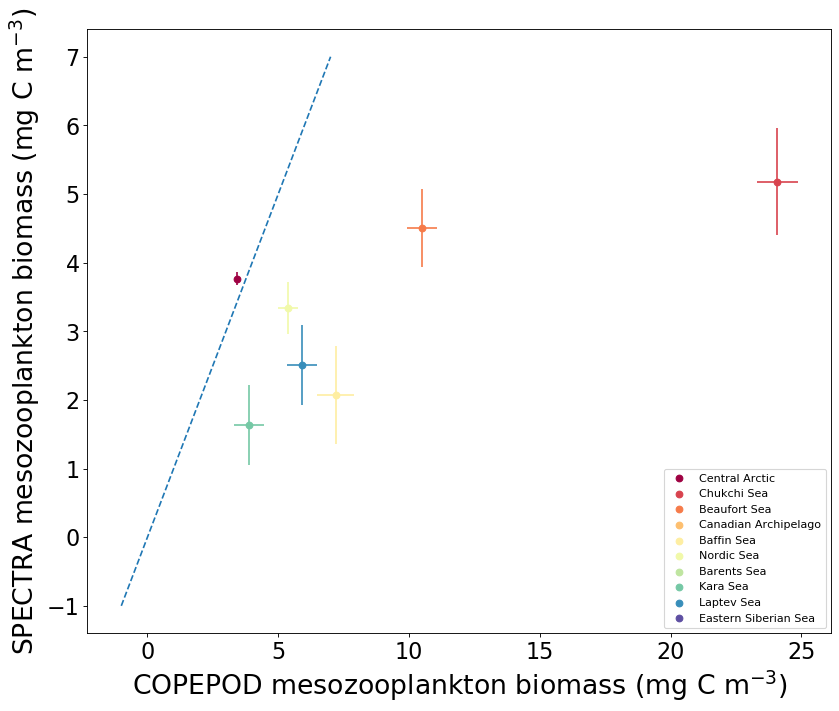

In [116]:
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

cmap=matplotlib.cm.get_cmap('Spectral', 10)

plt.scatter(np.nanmean(obs_ao),np.nanmean(model_ao),color=cmap(0),label='Central Arctic')
plt.errorbar(np.nanmean(obs_ao),np.nanmean(model_ao),yerr=err_ao,xerr=err_ao, color=cmap(0),linestyle="None")

plt.scatter(np.nanmean(obs_cs),np.nanmean(model_cs),color=cmap(1),label='Chukchi Sea')
plt.errorbar(np.nanmean(obs_cs),np.nanmean(model_cs),yerr=err_cs,xerr=err_cs, color=cmap(1),linestyle="None")

plt.scatter(np.nanmean(obs_bs),np.nanmean(model_bs), color=cmap(2),label='Beaufort Sea')
plt.errorbar(np.nanmean(obs_bs),np.nanmean(model_bs),yerr=err_bs,xerr=err_bs, color=cmap(2),linestyle="None")

plt.scatter(np.nanmean(obs_ca),np.nanmean(model_ca), color=cmap(3),label='Canadian Archipelago')
plt.errorbar(np.nanmean(obs_ca),np.nanmean(model_ca),yerr=err_ca,xerr=err_ca, color=cmap(3),linestyle="None")

plt.scatter(np.nanmean(obs_bb),np.nanmean(model_bb), color=cmap(4),label='Baffin Sea')
plt.errorbar(np.nanmean(obs_bb),np.nanmean(model_bb),yerr=err_bb,xerr=err_bb, color=cmap(4),linestyle="None")

plt.scatter(np.nanmean(obs_ess),np.nanmean(model_ess), color=cmap(5),label='Nordic Sea')
plt.errorbar(np.nanmean(obs_ess),np.nanmean(model_ess),yerr=err_ess,xerr=err_ess, color=cmap(5),linestyle="None")

plt.scatter(np.nanmean(obs_ls),np.nanmean(model_ls),color=cmap(6),label='Barents Sea')
plt.errorbar(np.nanmean(obs_ls),np.nanmean(model_ls),yerr=err_ls,xerr=err_ls, color=cmap(6),linestyle="None")

plt.scatter(np.nanmean(obs_ns),np.nanmean(model_ns), color=cmap(7),label='Kara Sea')
plt.errorbar(np.nanmean(obs_ns),np.nanmean(model_ns),yerr=err_ns,xerr=err_ns, color=cmap(7),linestyle="None")

plt.scatter(np.nanmean(obs_bts),np.nanmean(model_bts), color=cmap(8),label='Laptev Sea')
plt.errorbar(np.nanmean(obs_bts),np.nanmean(model_bts),yerr=err_bts,xerr=err_bts, color=cmap(8),linestyle="None")

plt.scatter(np.nanmean(obs_ks),np.nanmean(model_ks), color=cmap(9),label='Eastern Siberian Sea')
plt.errorbar(np.nanmean(obs_ks),np.nanmean(model_ks),yerr=err_ks,xerr=err_ks, color=cmap(9),linestyle="None")

plt.plot([-1,0,1,2,3,4,5,6,7], [-1,0,1,2,3,4,5,6,7], '--')

plt.legend(loc='lower right')
plt.ylabel('SPECTRA mesozooplankton biomass (mg C m$^{-3}$)', fontsize=24)
plt.xlabel('COPEPOD mesozooplankton biomass (mg C m$^{-3}$)', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)

plt.show()


## This is setting different errors in the x than in the y axis by finding the fraction of error from the observed and from the error, as such :
error in the y = percent error = (obs - model)/model * 100
error in the x = percent error = (model - obs)/obs * 100

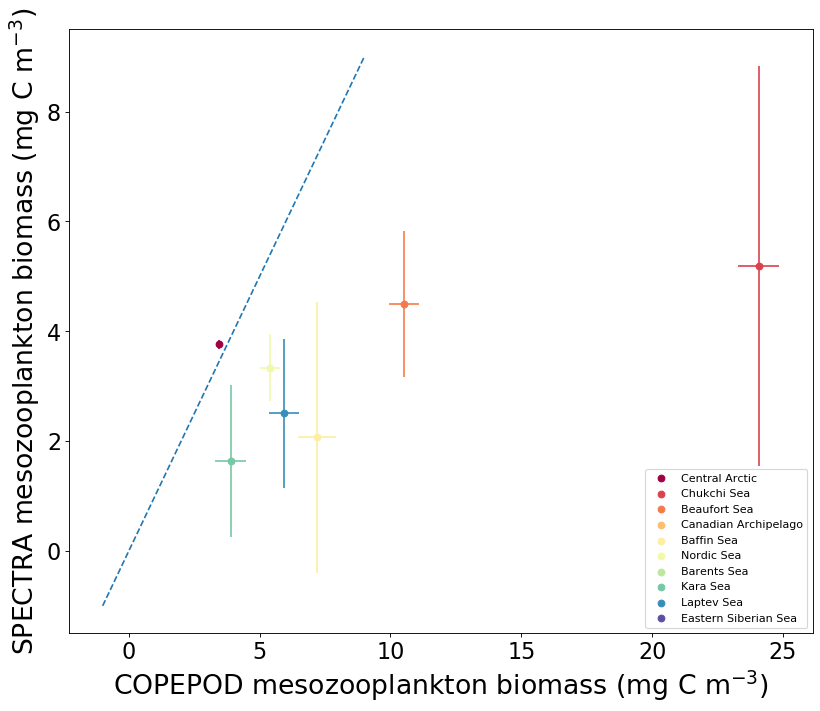

In [118]:
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

cmap=matplotlib.cm.get_cmap('Spectral', 10)

plt.scatter(np.nanmean(obs_ao),np.nanmean(model_ao),color=cmap(0),label='Central Arctic')
plt.errorbar(np.nanmean(obs_ao),np.nanmean(model_ao),yerr=err_aom,xerr=err_ao, color=cmap(0),linestyle="None")

plt.scatter(np.nanmean(obs_cs),np.nanmean(model_cs),color=cmap(1),label='Chukchi Sea')
plt.errorbar(np.nanmean(obs_cs),np.nanmean(model_cs),yerr=err_csm,xerr=err_cs, color=cmap(1),linestyle="None")

plt.scatter(np.nanmean(obs_bs),np.nanmean(model_bs), color=cmap(2),label='Beaufort Sea')
plt.errorbar(np.nanmean(obs_bs),np.nanmean(model_bs),yerr=err_bsm,xerr=err_bs, color=cmap(2),linestyle="None")

plt.scatter(np.nanmean(obs_ca),np.nanmean(model_ca), color=cmap(3),label='Canadian Archipelago')
plt.errorbar(np.nanmean(obs_ca),np.nanmean(model_ca),yerr=err_cam,xerr=err_ca, color=cmap(3),linestyle="None")

plt.scatter(np.nanmean(obs_bb),np.nanmean(model_bb), color=cmap(4),label='Baffin Sea')
plt.errorbar(np.nanmean(obs_bb),np.nanmean(model_bb),yerr=err_bbm,xerr=err_bb, color=cmap(4),linestyle="None")

plt.scatter(np.nanmean(obs_ess),np.nanmean(model_ess), color=cmap(5),label='Nordic Sea')
plt.errorbar(np.nanmean(obs_ess),np.nanmean(model_ess),yerr=err_essm,xerr=err_ess, color=cmap(5),linestyle="None")

plt.scatter(np.nanmean(obs_ls),np.nanmean(model_ls),color=cmap(6),label='Barents Sea')
plt.errorbar(np.nanmean(obs_ls),np.nanmean(model_ls),yerr=err_lsm,xerr=err_ls, color=cmap(6),linestyle="None")

plt.scatter(np.nanmean(obs_ns),np.nanmean(model_ns), color=cmap(7),label='Kara Sea')
plt.errorbar(np.nanmean(obs_ns),np.nanmean(model_ns),yerr=err_nsm,xerr=err_ns, color=cmap(7),linestyle="None")

plt.scatter(np.nanmean(obs_bts),np.nanmean(model_bts), color=cmap(8),label='Laptev Sea')
plt.errorbar(np.nanmean(obs_bts),np.nanmean(model_bts),yerr=err_btsm,xerr=err_bts, color=cmap(8),linestyle="None")

plt.scatter(np.nanmean(obs_ks),np.nanmean(model_ks), color=cmap(9),label='Eastern Siberian Sea')
plt.errorbar(np.nanmean(obs_ks),np.nanmean(model_ks),yerr=err_ksm,xerr=err_ks, color=cmap(9),linestyle="None")

plt.plot([-1,0,1,2,3,4,5,6,7,8,9], [-1,0,1,2,3,4,5,6,7,8,9], '--')

plt.legend(loc='lower right')
plt.ylabel('SPECTRA mesozooplankton biomass (mg C m$^{-3}$)', fontsize=24)
plt.xlabel('COPEPOD mesozooplankton biomass (mg C m$^{-3}$)', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)

plt.show()

## Now create one, but from the standrard devation from the mean in the x and in the y axis, I think this might be the correct way to do it. 

In [ ]:
# Model Chlorophyll for every region 
model_ao = np.nanmean(model_meso[170:180,:], axis=(0,1))
model_cs = np.nanmean(model_meso[149:170,0:25], axis=(0,1))
model_bs = np.nanmean(model_meso[149:170,25:55], axis=(0,1))
model_ca = np.nanmean(model_meso[149:170,55:110], axis=(0,1))
model_bb = np.nanmean(model_meso[149:170,110:135], axis=(0,1))
model_ess = np.nanmean(model_meso[149:170,325:360], axis=(0,1))
model_ls = np.nanmean(model_meso[149:170,270:325], axis=(0,1))
model_ns = np.nanmean(model_meso[149:170,155:205], axis=(0,1))
model_bts =np.nanmean(model_meso[149:170,205:233], axis=(0,1))
model_ks = np.nanmean(model_meso[149:170,233:270], axis=(0,1))

# Observed Chlorophyll for every region. 
obs_ao = np.nanmean(dz.carbon_biomass.isel(time=0).values[170:180,:], axis=(0,1))
obs_cs = np.nanmean(dz.carbon_biomass.isel(time=0).values[149:170,0:25], axis=(0,1))
obs_bs = np.nanmean(dz.carbon_biomass.isel(time=0).values[149:170,25:55], axis=(0,1))
obs_ca = np.nanmean(dz.carbon_biomass.isel(time=0).values[149:170,55:110], axis=(0,1))
obs_bb = np.nanmean(dz.carbon_biomass.isel(time=0).values[149:170,110:135], axis=(0,1))
obs_ess = np.nanmean(dz.carbon_biomass.isel(time=0).values[149:170,325:360], axis=(0,1))
obs_ls = np.nanmean(dz.carbon_biomass.isel(time=0).values[149:170,270:325], axis=(0,1))
obs_ns = np.nanmean(dz.carbon_biomass.isel(time=0).values[149:170,155:205], axis=(0,1))
obs_bts =np.nanmean(dz.carbon_biomass.isel(time=0).values[149:170,205:233], axis=(0,1))
obs_ks = np.nanmean(dz.carbon_biomass.isel(time=0).values[149:170,233:270], axis=(0,1))

In [137]:
# This is the error on the mdoel
err_aom = np.nanstd(model_meso[170:180,:])
err_csm = np.nanstd(model_meso[149:170,0:25])
err_bsm = np.nanstd(model_meso[149:170,25:55])
err_cam = np.nanstd(model_meso[149:170,55:110])
err_bbm = np.nanstd(model_meso[149:170,110:135])
err_essm = np.nanstd(model_meso[149:170,325:360])
err_lsm = np.nanstd(model_meso[149:170,270:325])
err_nsm = np.nanstd(model_meso[149:170,155:205])
err_btsm = np.nanstd(model_meso[149:170,205:233])
err_ksm = np.nanstd(model_meso[149:170,233:270])

# This is the error on COPEPOD
err_ao = np.nanstd(dz.carbon_biomass.isel(time=0).values[170:180,:])
err_cs = np.nanstd(dz.carbon_biomass.isel(time=0).values[149:170,0:25])
err_bs = np.nanstd(dz.carbon_biomass.isel(time=0).values[149:170,25:55])
err_ca = np.nanstd(dz.carbon_biomass.isel(time=0).values[149:170,55:110])
err_bb = np.nanstd(dz.carbon_biomass.isel(time=0).values[149:170,110:135])
err_ess = np.nanstd(dz.carbon_biomass.isel(time=0).values[149:170,325:360])
err_ls = np.nanstd(dz.carbon_biomass.isel(time=0).values[149:170,270:325])
err_ns = np.nanstd(dz.carbon_biomass.isel(time=0).values[149:170,155:205])
err_bts = np.nanstd(dz.carbon_biomass.isel(time=0).values[149:170,205:233])
err_ks = np.nanstd(dz.carbon_biomass.isel(time=0).values[149:170,233:270])

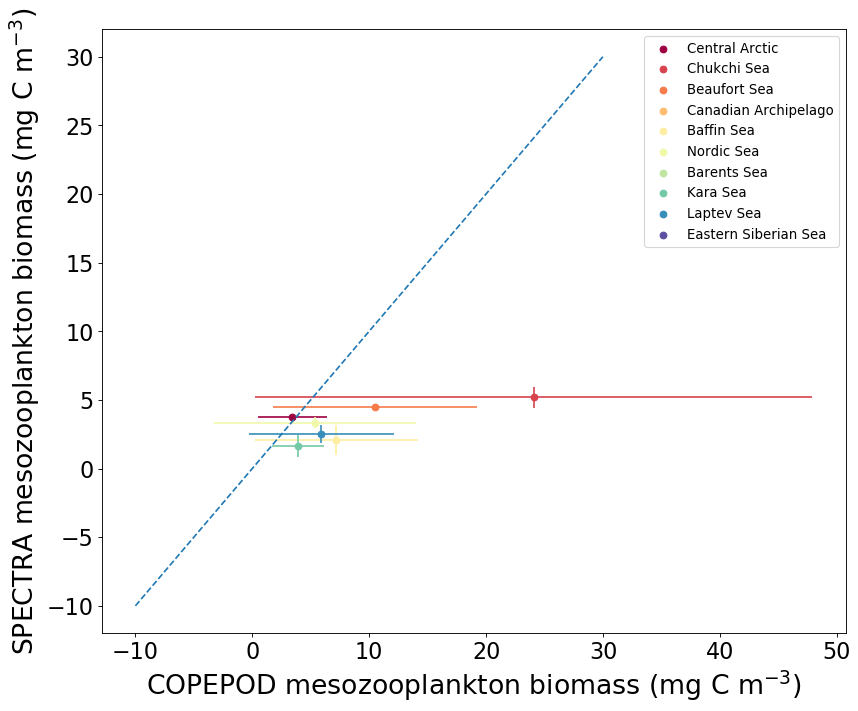

In [140]:
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

cmap=matplotlib.cm.get_cmap('Spectral', 10)

plt.scatter(np.nanmean(obs_ao),np.nanmean(model_ao),color=cmap(0),label='Central Arctic')
plt.errorbar(np.nanmean(obs_ao),np.nanmean(model_ao),yerr=err_aom,xerr=err_ao, color=cmap(0),linestyle="None")

plt.scatter(np.nanmean(obs_cs),np.nanmean(model_cs),color=cmap(1),label='Chukchi Sea')
plt.errorbar(np.nanmean(obs_cs),np.nanmean(model_cs),yerr=err_csm,xerr=err_cs, color=cmap(1),linestyle="None")

plt.scatter(np.nanmean(obs_bs),np.nanmean(model_bs), color=cmap(2),label='Beaufort Sea')
plt.errorbar(np.nanmean(obs_bs),np.nanmean(model_bs),yerr=err_bsm,xerr=err_bs, color=cmap(2),linestyle="None")

plt.scatter(np.nanmean(obs_ca),np.nanmean(model_ca), color=cmap(3),label='Canadian Archipelago')
plt.errorbar(np.nanmean(obs_ca),np.nanmean(model_ca),yerr=err_cam,xerr=err_ca, color=cmap(3),linestyle="None")

plt.scatter(np.nanmean(obs_bb),np.nanmean(model_bb), color=cmap(4),label='Baffin Sea')
plt.errorbar(np.nanmean(obs_bb),np.nanmean(model_bb),yerr=err_bbm,xerr=err_bb, color=cmap(4),linestyle="None")

plt.scatter(np.nanmean(obs_ess),np.nanmean(model_ess), color=cmap(5),label='Nordic Sea')
plt.errorbar(np.nanmean(obs_ess),np.nanmean(model_ess),yerr=err_essm,xerr=err_ess, color=cmap(5),linestyle="None")

plt.scatter(np.nanmean(obs_ls),np.nanmean(model_ls),color=cmap(6),label='Barents Sea')
plt.errorbar(np.nanmean(obs_ls),np.nanmean(model_ls),yerr=err_lsm,xerr=err_ls, color=cmap(6),linestyle="None")

plt.scatter(np.nanmean(obs_ns),np.nanmean(model_ns), color=cmap(7),label='Kara Sea')
plt.errorbar(np.nanmean(obs_ns),np.nanmean(model_ns),yerr=err_nsm,xerr=err_ns, color=cmap(7),linestyle="None")

plt.scatter(np.nanmean(obs_bts),np.nanmean(model_bts), color=cmap(8),label='Laptev Sea')
plt.errorbar(np.nanmean(obs_bts),np.nanmean(model_bts),yerr=err_btsm,xerr=err_bts, color=cmap(8),linestyle="None")

plt.scatter(np.nanmean(obs_ks),np.nanmean(model_ks), color=cmap(9),label='Eastern Siberian Sea')
plt.errorbar(np.nanmean(obs_ks),np.nanmean(model_ks),yerr=err_ksm,xerr=err_ks, color=cmap(9),linestyle="None")

plt.plot([-10,0,1,2,3,4,5,10,20,30], [-10,0,1,2,3,4,5,10,20,30], '--')

plt.legend(loc='top left', fontsize=12)
plt.ylabel('SPECTRA mesozooplankton biomass (mg C m$^{-3}$)', fontsize=24)
plt.xlabel('COPEPOD mesozooplankton biomass (mg C m$^{-3}$)', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)

plt.show()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Mesozooplankton_SPECTRA_COPEPOD_scatter_'+year+'year.png', dpi=600, bbox_inches='tight')